In [1]:
import pandas as pd 
data = pd.read_csv(r"C:\Users\dell\OneDrive\Bureau\NIDS\data\cic.csv")
print(data.shape)
data.head()

(1048575, 80)


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [2]:
import numpy as np
# Drop useless columns
data.drop(['Timestamp', 'Dst Port'], axis=1, inplace=True, errors="ignore")
# Drop duplicated rows
data.drop_duplicates(inplace=True)
data.shape

(619805, 78)

In [3]:
# Replace inf with NaN, then fill
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

In [4]:
# Remove columns with only one unique value
nunique = data.drop("Label", axis=1).nunique()
constant_cols = nunique[nunique == 1].index.tolist()

print("Dropping constant columns:", constant_cols)
data.drop(columns=constant_cols, inplace=True)

print("Shape after removing:", data.shape)


Dropping constant columns: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg']
Shape after removing: (619805, 68)


In [5]:
neg_cols = ['Init Fwd Win Byts', 'Init Bwd Win Byts']

for col in neg_cols:
    if col in data.columns:
        data = data[data[col] >= 0]
print("Shape after removing negative rows:", data.shape)


Shape after removing negative rows: (392941, 68)


In [6]:
print(data['Label'].value_counts())
# Convert attacks to "Malicious"
data.replace(to_replace=["FTP-BruteForce", "SSH-Bruteforce"], value="Malicious", inplace=True)


Label
Benign            298844
SSH-Bruteforce     94043
FTP-BruteForce        54
Name: count, dtype: int64


In [7]:
# Map to 0/1
label_mapping = {'Benign': 0, 'Malicious': 1}
data['Label'] = data['Label'].map(label_mapping)
print(data['Label'].value_counts())

Label
0    298844
1     94097
Name: count, dtype: int64


In [ ]:
selected_features = [
    'Protocol',
    'Flow Duration',
    'Tot Fwd Pkts',
    'Tot Bwd Pkts',
    'TotLen Fwd Pkts',
    'TotLen Bwd Pkts',
    'Fwd Pkt Len Mean',
    'Bwd Pkt Len Mean',
    'Flow Byts/s',
    'Flow Pkts/s',
    'Pkt Len Mean',
    'Pkt Len Std',
    'SYN Flag Cnt',
    'ACK Flag Cnt',
    'FIN Flag Cnt',
    'RST Flag Cnt',
    'PSH Flag Cnt',
    'URG Flag Cnt'
]

selected_features = [f for f in selected_features if f in data.columns]
print("Using features:", selected_features)


Using features: ['Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'ACK Flag Cnt', 'FIN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'URG Flag Cnt']


In [9]:
from sklearn.model_selection import train_test_split
X = data[selected_features]
y = data['Label']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42, stratify=y
)


In [10]:
x_train.shape

(275058, 18)

In [11]:
x_test.shape

(117883, 18)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

Accuracy:  0.9994825377705012
Precision:  0.9993617926535243
F1 score:  0.9989190721740825
Recall Score:  0.998476743774133


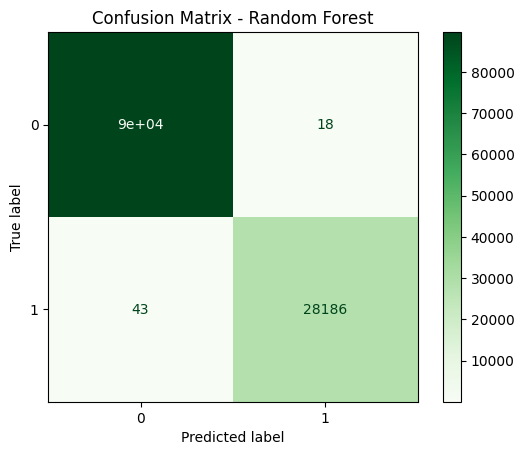

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
y_predictrf = rf.predict(X_test_scaled)
accuracyrf = accuracy_score(y_test,y_predictrf)
print("Accuracy: ", accuracyrf)
precisionrf = precision_score(y_test, y_predictrf)
print("Precision: ",precisionrf)
f1rf = f1_score(y_test, y_predictrf)
print("F1 score: ",f1rf)
recallscorerf= recall_score(y_test, y_predictrf)
print("Recall Score: ",recallscorerf)
cm_rf = confusion_matrix(y_test, y_predictrf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [14]:
import joblib
import json
import os 

os.makedirs('models', exist_ok=True)

# Save model
joblib.dump(rf, 'models/random_forest_model.pkl')
print("Random Forest model Saved in models/random_forest_model.pkl")
# Save scaler
joblib.dump(scaler, 'models/scaler.pkl')
print("StandardScaler saved in models/scaler.pkl")
# Save feature list
with open("features.json", "w") as f:
    json.dump(selected_features, f)


Random Forest model Saved in models/random_forest_model.pkl
StandardScaler saved in models/scaler.pkl
